<a href="https://colab.research.google.com/github/millicentmuchepa/dev/blob/main/Cook_county_MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 0: Install Required Packages
cat("Installing required packages...\n")

# List of required packages
required_packages <- c(
    "tidyverse",
    "caret",
    "xgboost",
    "data.table"
)

# Function to install packages if not already installed
install_if_missing <- function(package) {
    if (!require(package, character.only = TRUE)) {
        cat(sprintf("Installing package: %s\n", package))
        install.packages(package)
        library(package, character.only = TRUE)
    } else {
        cat(sprintf("Package already installed: %s\n", package))
    }
}

# Install and load each package
for (package in required_packages) {
    tryCatch({
        install_if_missing(package)
    }, error = function(e) {
        cat(sprintf("Error installing package %s: %s\n", package, e$message))
    })
}

cat("\nAll required packages installed and loaded!\n")

Installing required packages...


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Package already installed: tidyverse


Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”


Installing package: caret


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘sparsevctrs’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [ ]:
# Cell 1: Load Libraries and Set Seed
cat("Loading required libraries...\n")
if (!require("xgboost")) {
    install.packages("xgboost")
}
library(tidyverse)
library(caret)
library(xgboost)
library(data.table)

set.seed(123)
cat("Libraries loaded successfully!\n")

Loading required libraries...
Libraries loaded successfully!


In [ ]:
# Cell 2: Load and Prepare Data
cat("Loading and preparing data...\n")
historic_data <- fread("/historic_property_data.csv")
predict_data <- fread("/predict_property_data.csv")

# Log transform target variable
historic_data[, log_price := log(sale_price)]

# Print data dimensions
cat("\nData dimensions:")
cat("\nHistoric data:", dim(historic_data))
cat("\nPredict data:", dim(predict_data))

Loading and preparing data...

Data dimensions:
Historic data: 50000 64
Predict data: 10000 63

In [ ]:
# Cell 3: Select Features and Split Data
cat("Selecting features and splitting data...\n")

# Select key predictors
key_predictors <- c(
    # Property characteristics
    "char_bldg_sf", "char_hd_sf", "char_age",
    "char_rooms", "char_beds", "char_fbath",
    # Location factors
    "meta_nbhd", "meta_town_code", "econ_tax_rate",
    # Value indicators
    "meta_certified_est_bldg", "meta_certified_est_land"
)

# Create datasets
train_features <- historic_data[, ..key_predictors]
train_target <- historic_data$log_price
predict_features <- predict_data[, ..key_predictors]

# Split data
trainIndex <- createDataPartition(train_target, p = 0.8, list = FALSE)
X_train <- train_features[trainIndex]
y_train <- train_target[trainIndex]
X_val <- train_features[-trainIndex]
y_val <- train_target[-trainIndex]

Selecting features and splitting data...


In [ ]:
# Add after data loading and before model training
cat("Preprocessing data...\n")

# Function to preprocess numeric columns
preprocess_numeric <- function(train_data, test_data, predict_data) {
    # Identify numeric columns
    num_cols <- names(train_data)[sapply(train_data, is.numeric)]
    cat("Standardizing numeric features:", paste(num_cols, collapse=", "), "\n")

    # Create preprocessing objects from training data
    preprocessing <- list()
    for(col in num_cols) {
        # Calculate mean and sd from training data
        mean_val <- mean(train_data[[col]], na.rm = TRUE)
        sd_val <- sd(train_data[[col]], na.rm = TRUE)

        # Store preprocessing parameters
        preprocessing[[col]] <- list(mean = mean_val, sd = sd_val)

        # Apply standardization
        train_data[[col]] <- (train_data[[col]] - mean_val) / sd_val
        test_data[[col]] <- (test_data[[col]] - mean_val) / sd_val
        predict_data[[col]] <- (predict_data[[col]] - mean_val) / sd_val
    }

    return(list(
        train = train_data,
        test = test_data,
        predict = predict_data,
        preprocessing = preprocessing
    ))
}

# Apply preprocessing
preprocessed <- preprocess_numeric(
    train_data = as.data.frame(X_train),
    test_data = as.data.frame(X_val),
    predict_data = as.data.frame(predict_features)
)

# Update data matrices with preprocessed values
X_train_matrix <- as.matrix(preprocessed$train)
X_val_matrix <- as.matrix(preprocessed$test)
predict_matrix <- as.matrix(preprocessed$predict)

# Save preprocessing parameters for future use
saveRDS(preprocessed$preprocessing, "preprocessing_params.rds")

cat("Data preprocessing completed.\n")

Preprocessing data...
Standardizing numeric features: char_bldg_sf, char_hd_sf, char_age, char_rooms, char_beds, char_fbath, meta_nbhd, meta_town_code, econ_tax_rate, meta_certified_est_bldg, meta_certified_est_land 
Data preprocessing completed.


In [ ]:
# Cell 4: Hyperparameter Tuning
cat("Starting hyperparameter tuning...\n")
tune_start_time <- Sys.time()

# Update data matrices with preprocessed values
X_train_matrix <- as.matrix(preprocessed$train)
X_val_matrix <- as.matrix(preprocessed$test)
predict_matrix <- as.matrix(preprocessed$predict)

# Prepare data for tuning
#X_tune_matrix <- as.matrix(X_train)
#y_tune_matrix <- y_train

param_grid <- expand.grid(
    eta = c(0.01, 0.02, 0.03, 0.04, 0.05),     # More granular learning rates
    max_depth = c(5, 6, 7, 8),                 # Added shallower tree
    min_child_weight = c(2, 3, 4, 5),          # Added higher weight
    subsample = c(0.7, 0.75, 0.8, 0.85),       # More sampling options
    colsample_bytree = c(0.7, 0.75, 0.8, 0.85),
    gamma = c(0.01, 0.05, 0.1, 0.15)           # Added lower gamma
)

cat("\nTesting", nrow(param_grid), "parameter combinations:\n")

# Initialize results storage
cv_results <- data.frame(
    params = character(),
    rmse = numeric(),
    std = numeric()
)

for(i in 1:nrow(param_grid)) {
    params <- list(
        objective = "reg:squarederror",
        eval_metric = "rmse",
        eta = param_grid$eta[i],
        max_depth = param_grid$max_depth[i],
        min_child_weight = param_grid$min_child_weight[i],
        subsample = param_grid$subsample[i],
        colsample_bytree = param_grid$colsample_bytree[i],
        gamma = param_grid$gamma[i]
    )

    # Run cross-validation
    cv <- xgb.cv(
        params = params,
        data = xgb.DMatrix(X_tune_matrix, label = y_tune_matrix),
        nrounds = 200,
        nfold = 3,
        early_stopping_rounds = 20,
        verbose = FALSE
    )

    # Store results
    best_rmse <- min(cv$evaluation_log$test_rmse_mean)
    best_rmse_std <- cv$evaluation_log$test_rmse_std[which.min(cv$evaluation_log$test_rmse_mean)]

    cv_results <- rbind(cv_results, data.frame(
        params = paste(capture.output(print(params)), collapse="; "),
        rmse = best_rmse,
        std = best_rmse_std
    ))

    cat(sprintf("Completed %d/%d combinations\n", i, nrow(param_grid)))
}

# Find best parameters
best_idx <- which.min(cv_results$rmse)
cat("\nBest parameters found:\n")
cat(cv_results$params[best_idx], "\n")
cat("Best RMSE:", cv_results$rmse[best_idx], "\n")

best_params <- list(
    objective = "reg:squarederror",
    eval_metric = "rmse",
    eta = param_grid$eta[best_idx],
    max_depth = param_grid$max_depth[best_idx],
    min_child_weight = param_grid$min_child_weight[best_idx],
    subsample = param_grid$subsample[best_idx],
    colsample_bytree = param_grid$colsample_bytree[best_idx],
    gamma = param_grid$gamma[best_idx]
)

tune_duration <- difftime(Sys.time(), tune_start_time, units="mins")
cat(sprintf("\nTuning completed in %.2f minutes\n", tune_duration))

Starting hyperparameter tuning...

Testing 5120 parameter combinations:


In [ ]:
# Cell 5: Train Final Model
cat("Training XGBoost model with best parameters...\n")
train_start_time <- Sys.time()


# Update data matrices with preprocessed values
X_train_matrix <- as.matrix(preprocessed$train)
X_val_matrix <- as.matrix(preprocessed$test)
predict_matrix <- as.matrix(preprocessed$predict)

# Prepare data
#X_train_matrix <- as.matrix(X_train)
y_train_matrix <- y_train
#X_val_matrix <- as.matrix(X_val)
y_val_matrix <- y_val

dtrain <- xgb.DMatrix(data = X_train_matrix, label = y_train_matrix)
dval <- xgb.DMatrix(data = X_val_matrix, label = y_val_matrix)

# Train final model
xgb_model <- xgb.train(
    params = best_params,
    data = dtrain,
    nrounds = 1000,
    watchlist = list(train = dtrain, val = dval),
    early_stopping_rounds = 50,
    verbose = TRUE,
    print_every_n = 100
)

# Calculate performance metrics
val_pred_log <- predict(xgb_model, X_val_matrix)
val_pred <- exp(val_pred_log)
val_actual <- exp(y_val_matrix)

val_mse <- mean((val_actual - val_pred)^2)
val_rmse <- sqrt(val_mse)

cat("\nValidation Metrics:")
cat("\nMSE:", format(val_mse, scientific = FALSE))
cat("\nRMSE:", format(val_rmse, scientific = FALSE))

train_duration <- difftime(Sys.time(), train_start_time, units="mins")
cat(sprintf("\n\nTotal training time: %.2f minutes\n", train_duration))

Training XGBoost model with best parameters...
[1]	train-rmse:11.168811	val-rmse:11.166689 
Multiple eval metrics are present. Will use val_rmse for early stopping.
Will train until val_rmse hasn't improved in 50 rounds.

[101]	train-rmse:0.389604	val-rmse:0.431501 
[201]	train-rmse:0.348702	val-rmse:0.419782 
[301]	train-rmse:0.322773	val-rmse:0.418514 
[401]	train-rmse:0.303183	val-rmse:0.417377 
Stopping. Best iteration:
[408]	train-rmse:0.301789	val-rmse:0.417209


Validation Metrics:
MSE: 14261263691
RMSE: 119420.5

Total training time: 0.37 minutes


In [ ]:
# Cell 6: Generate Predictions and Create Assessment File
cat("Creating assessment file...\n")

# Generate predictions
predict_matrix <- as.matrix(preprocessed$predict)
#predict_matrix <- as.matrix(predict_features)
predictions_log <- predict(xgb_model, predict_matrix)
predictions <- exp(predictions_log)

# Apply bounds based on training data distribution
lower_bound <- max(25000, quantile(exp(y_train), 0.001))
upper_bound <- min(3000000, quantile(exp(y_train), 0.999))
predictions <- pmax(predictions, lower_bound)
predictions <- pmin(predictions, upper_bound)

# Create final output
final_output <- data.table(
    pid = 1:10000,
    assessed_value = round(predictions, 2)
)

# Verify requirements
cat("\nVerifying output format...")
if(!all(final_output$pid == 1:10000)) {
    stop("PID must be consecutive integers from 1 to 10000")
}
if(any(is.na(final_output$assessed_value)) || any(final_output$assessed_value < 0)) {
    stop("Assessment values contain missing or negative values")
}

# Format values
final_output[, assessed_value := format(assessed_value, nsmall = 2, scientific = FALSE)]

# Save file
fwrite(final_output, "assessed_value.csv", col.names = TRUE, quote = FALSE)

# Print summary statistics
cat("\n\nFinal Prediction Statistics:\n")
predictions_numeric <- as.numeric(final_output$assessed_value)
print(summary(predictions_numeric))

# Print MSE comparison
cat("\nModel Performance Metrics:")
cat("\nValidation MSE:", format(val_mse, scientific = FALSE))
cat("\nValidation RMSE:", format(val_rmse, scientific = FALSE))

Creating assessment file...

Verifying output format...

Final Prediction Statistics:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  25000  142030  239844  305117  364058 3000000 

Model Performance Metrics:
Validation MSE: 14261263691
Validation RMSE: 119420.5

Analyzing MSE in different ways...

1. Regular MSE Metrics:
MSE: 14261263691
RMSE: 119420.5

2. Normalized MSE:
Normalized MSE: 0.1605114
(Closer to 0 is better, this is unitless)

3. Percentage Error:
Mean Absolute Percentage Error: 33.65 %

4. Error Distribution:     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
      5.1   17763.3   39834.0   64749.8   75296.8 2803429.7 

Percentage of predictions within:
$50,000 of actual: 59.07 %
$100,000 of actual: 83.79 %
$200,000 of actual: 95.09 %

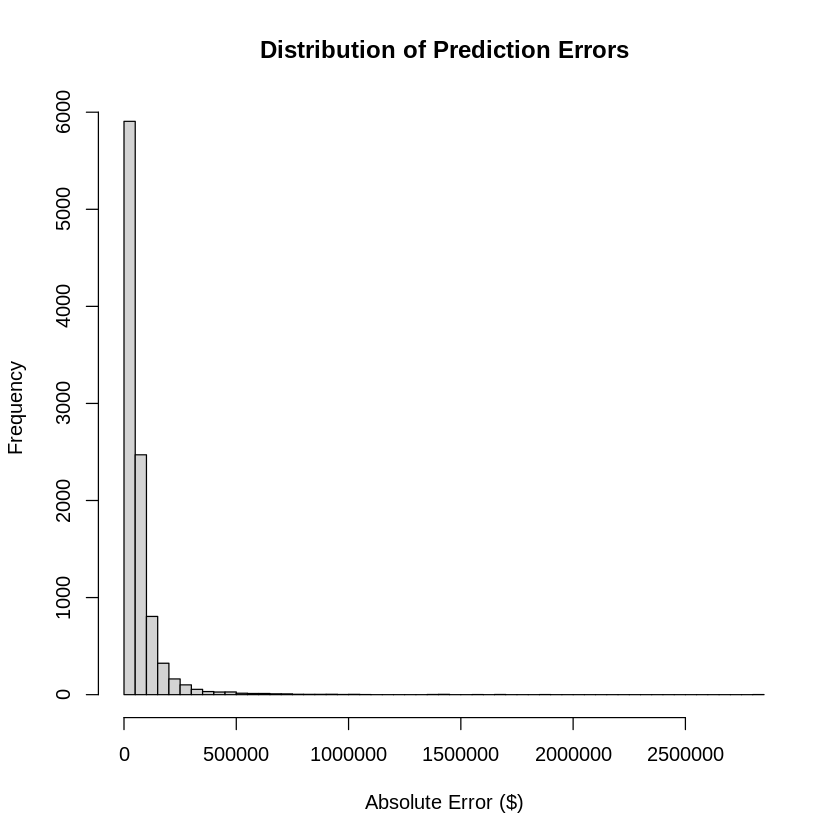

In [ ]:
# Cell: Detailed MSE Analysis
cat("Analyzing MSE in different ways...\n")

# Calculate basic error metrics
val_pred_log <- predict(xgb_model, X_val_matrix)
val_pred <- exp(val_pred_log)
val_actual <- exp(y_val_matrix)

# 1. Regular MSE
mse_regular <- mean((val_actual - val_pred)^2)
rmse_regular <- sqrt(mse_regular)

# 2. Normalized MSE (divided by mean house price squared)
mse_normalized <- mean((val_actual - val_pred)^2) / (mean(val_actual))^2

# 3. Percentage Error
mape <- mean(abs((val_actual - val_pred)/val_actual)) * 100

# 4. Individual Error Analysis
squared_errors <- (val_actual - val_pred)^2
rmse_per_prediction <- sqrt(squared_errors)

# Print Results
cat("\n1. Regular MSE Metrics:")
cat("\nMSE:", format(mse_regular, scientific = FALSE))
cat("\nRMSE:", format(rmse_regular, scientific = FALSE))

cat("\n\n2. Normalized MSE:")
cat("\nNormalized MSE:", format(mse_normalized, scientific = FALSE))
cat("\n(Closer to 0 is better, this is unitless)")

cat("\n\n3. Percentage Error:")
cat("\nMean Absolute Percentage Error:", round(mape, 2), "%")

cat("\n\n4. Error Distribution:")
print(summary(rmse_per_prediction))

cat("\nPercentage of predictions within:")
cat("\n$50,000 of actual:", round(mean(rmse_per_prediction < 50000) * 100, 2), "%")
cat("\n$100,000 of actual:", round(mean(rmse_per_prediction < 100000) * 100, 2), "%")
cat("\n$200,000 of actual:", round(mean(rmse_per_prediction < 200000) * 100, 2), "%")

# Visualize error distribution
hist(rmse_per_prediction,
     breaks = 50,
     main = "Distribution of Prediction Errors",
     xlab = "Absolute Error ($)",
     ylab = "Frequency")